### Training Diffusion Model 

Diffusion models are denoising models .We dont train model directly to generate images . Instead we train it to remove noise from images . During Training we add noise to images. And model has to predict noise present in image.

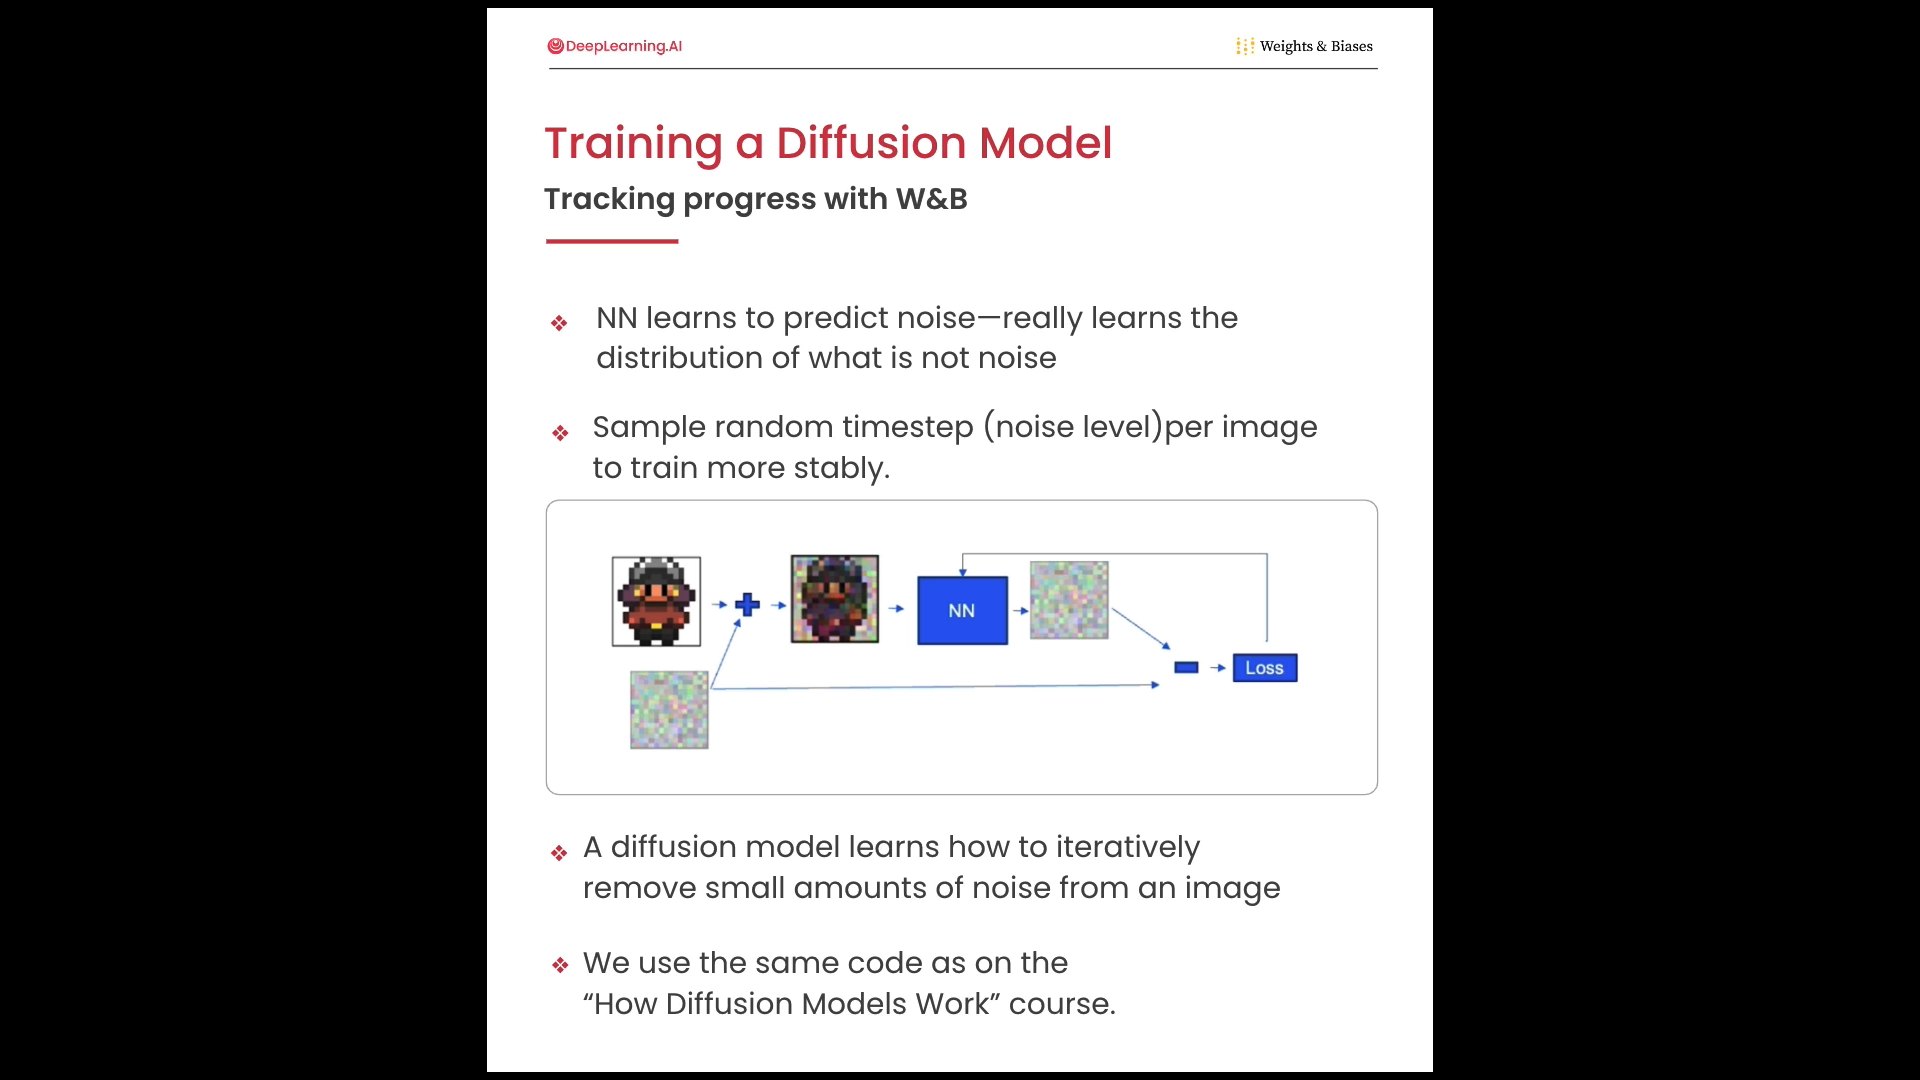

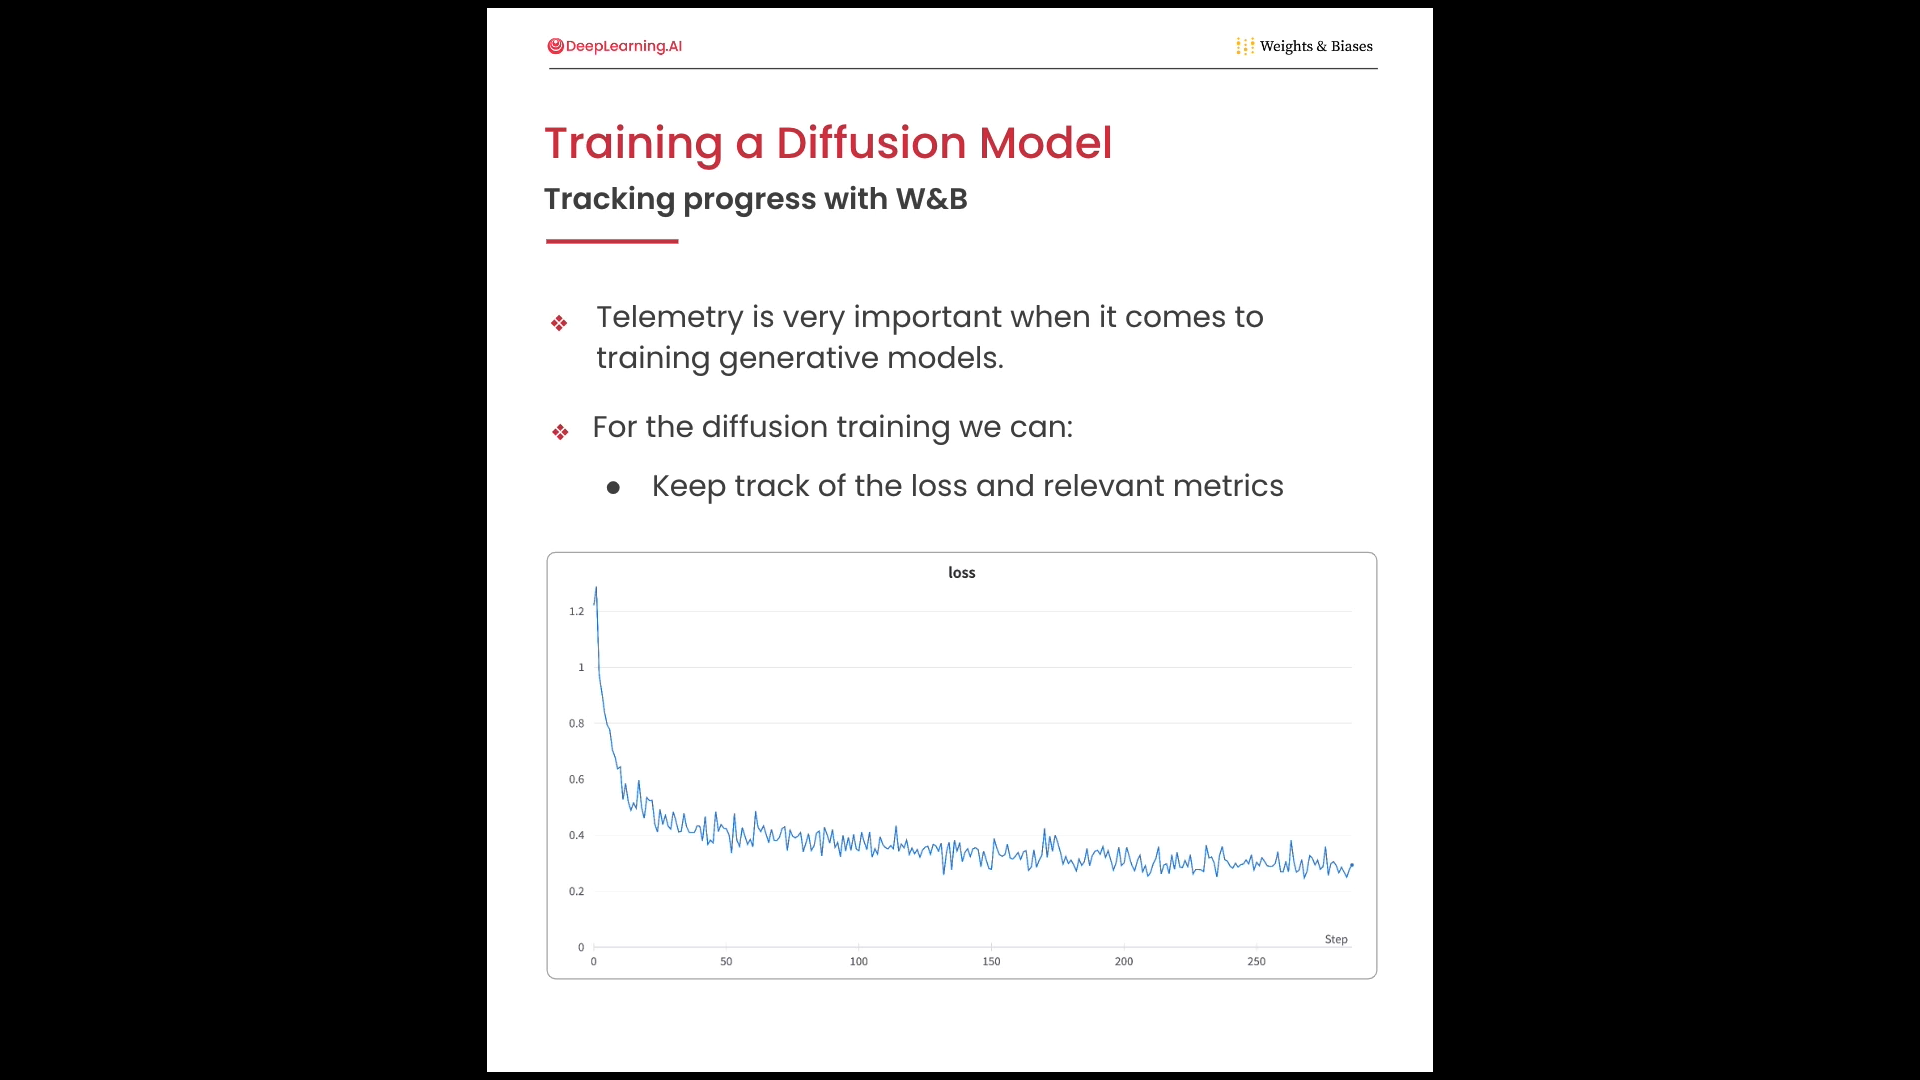

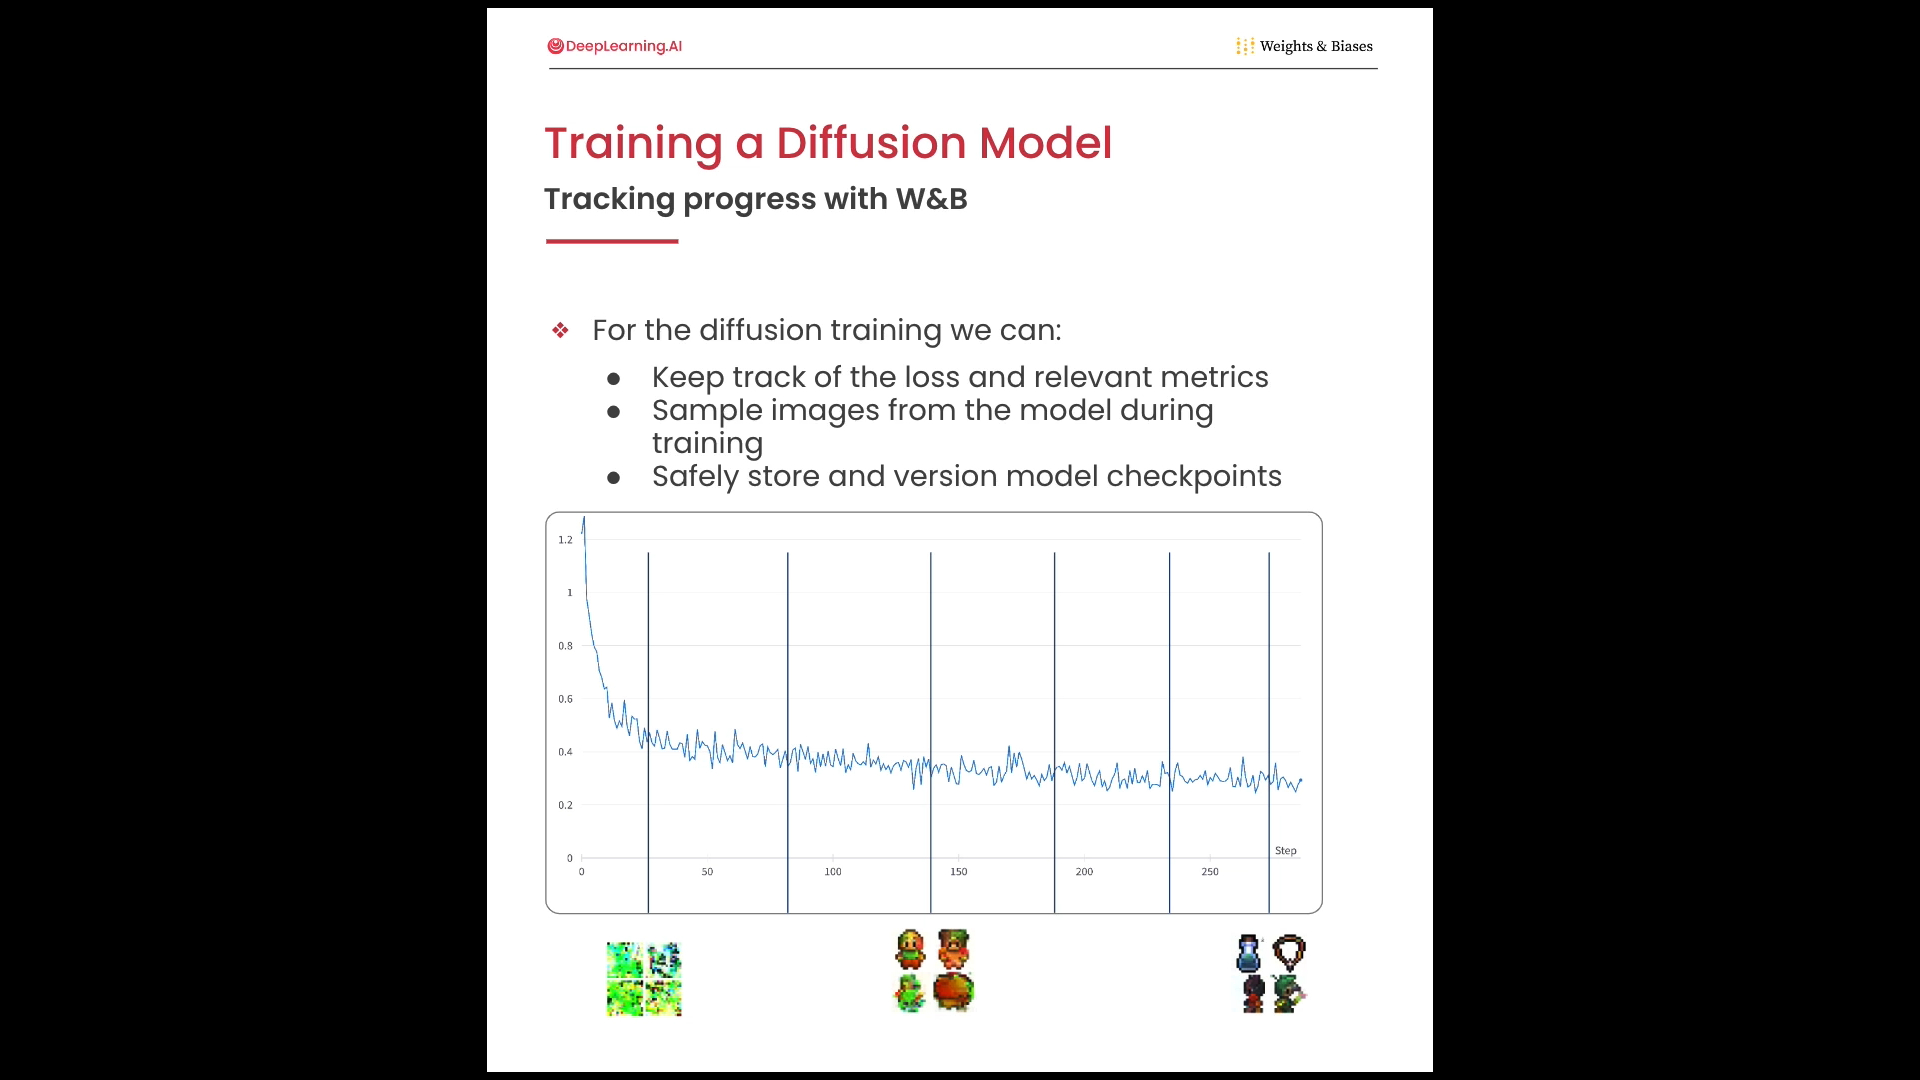

In [ ]:
from types import SimpleNamespace
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from utilities import *

import wandb

In [ ]:
wandb.login(anonymous="allow")

# we are storing the parameters to be logged to wandb
DATA_DIR = Path('./data/')
SAVE_DIR = Path('./data/weights/')
SAVE_DIR.mkdir(exist_ok=True, parents=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = SimpleNamespace(
    # hyperparameters
    num_samples = 30,

    # diffusion hyperparameters
    timesteps = 500,
    beta1 = 1e-4,
    beta2 = 0.02,

    # network hyperparameters
    n_feat = 64, # 64 hidden dimension feature
    n_cfeat = 5, # context vector is of size 5
    height = 16, # 16x16 image
    
    # training hyperparameters
    batch_size = 100,
    n_epoch = 32,
    lrate = 1e-3,
)

### Setup DDPM noise scheduler and sampler (same as in the Diffusion course). 
- perturb_input: Adds noise to the input image at the corresponding timestep on the schedule
- sample_ddpm_context: Generate images using the DDPM sampler, we will use this function during training to sample from the model regularly and see how our training is progressing

In [ ]:
# setup ddpm sampler functions
perturb_input, sample_ddpm_context = setup_ddpm(config.beta1, 
                                                config.beta2, 
                                                config.timesteps, 
                                                DEVICE)

# construct model
nn_model = ContextUnet(in_channels=3, 
                       n_feat=config.n_feat, 
                       n_cfeat=config.n_cfeat, 
                       height=config.height).to(DEVICE)

# load dataset and construct optimizer
dataset = CustomDataset.from_np(path=DATA_DIR)
dataloader = DataLoader(dataset, 
                        batch_size=config.batch_size, 
                        shuffle=True)
optim = torch.optim.Adam(nn_model.parameters(), lr=config.lrate)

### Training

We choose a fixed context vector with 6 samples of each class to guide our diffusion

In [ ]:
# Noise vector
# x_T ~ N(0, 1), sample initial noise
noises = torch.randn(config.num_samples, 3, 
                     config.height, config.height).to(DEVICE)  

# A fixed context vector to sample from
ctx_vector = F.one_hot(torch.tensor([0,0,0,0,0,0,   # hero
                                     1,1,1,1,1,1,   # non-hero
                                     2,2,2,2,2,2,   # food
                                     3,3,3,3,3,3,   # spell
                                     4,4,4,4,4,4]), # side-facing 
                       5).to(DEVICE).float()

The following training cell takes very long to run on CPU, we have already trained the model for you on a GPU equipped machine.

### You can visit the result of this >> [training here](https://wandb.ai/dlai-course/dlai_sprite_diffusion/runs/pzs3gsyo) <<

In [ ]:
# create a wandb run
run = wandb.init(project="dlai_sprite_diffusion", 
                 job_type="train", 
                 config=config)

# we pass the config back from W&B
config = wandb.config

for ep in tqdm(range(config.n_epoch), leave=True, total=config.n_epoch):
    # set into train mode
    nn_model.train()
    optim.param_groups[0]['lr'] = config.lrate*(1-ep/config.n_epoch)
    
    pbar = tqdm(dataloader, leave=False)
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(DEVICE)
        c = c.to(DEVICE)   
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.8).to(DEVICE)
        c = c * context_mask.unsqueeze(-1)        
        noise = torch.randn_like(x)
        t = torch.randint(1, config.timesteps + 1, (x.shape[0],)).to(DEVICE) 
        x_pert = perturb_input(x, t, noise)      
        pred_noise = nn_model(x_pert, t / config.timesteps, c=c)      
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()    
        optim.step()

        wandb.log({"loss": loss.item(),
                   "lr": optim.param_groups[0]['lr'],
                   "epoch": ep})


    # save model periodically
    if ep%4==0 or ep == int(config.n_epoch-1):
        nn_model.eval()
        ckpt_file = SAVE_DIR/f"context_model.pth"
        torch.save(nn_model.state_dict(), ckpt_file)

        artifact_name = f"{wandb.run.id}_context_model"
        at = wandb.Artifact(artifact_name, type="model")
        at.add_file(ckpt_file)
        wandb.log_artifact(at, aliases=[f"epoch_{ep}"])

        samples, _ = sample_ddpm_context(nn_model, 
                                         noises, 
                                         ctx_vector[:config.num_samples])
        wandb.log({
            "train_samples": [
                wandb.Image(img) for img in samples.split(1)
            ]})
        
# finish W&B run
wandb.finish()

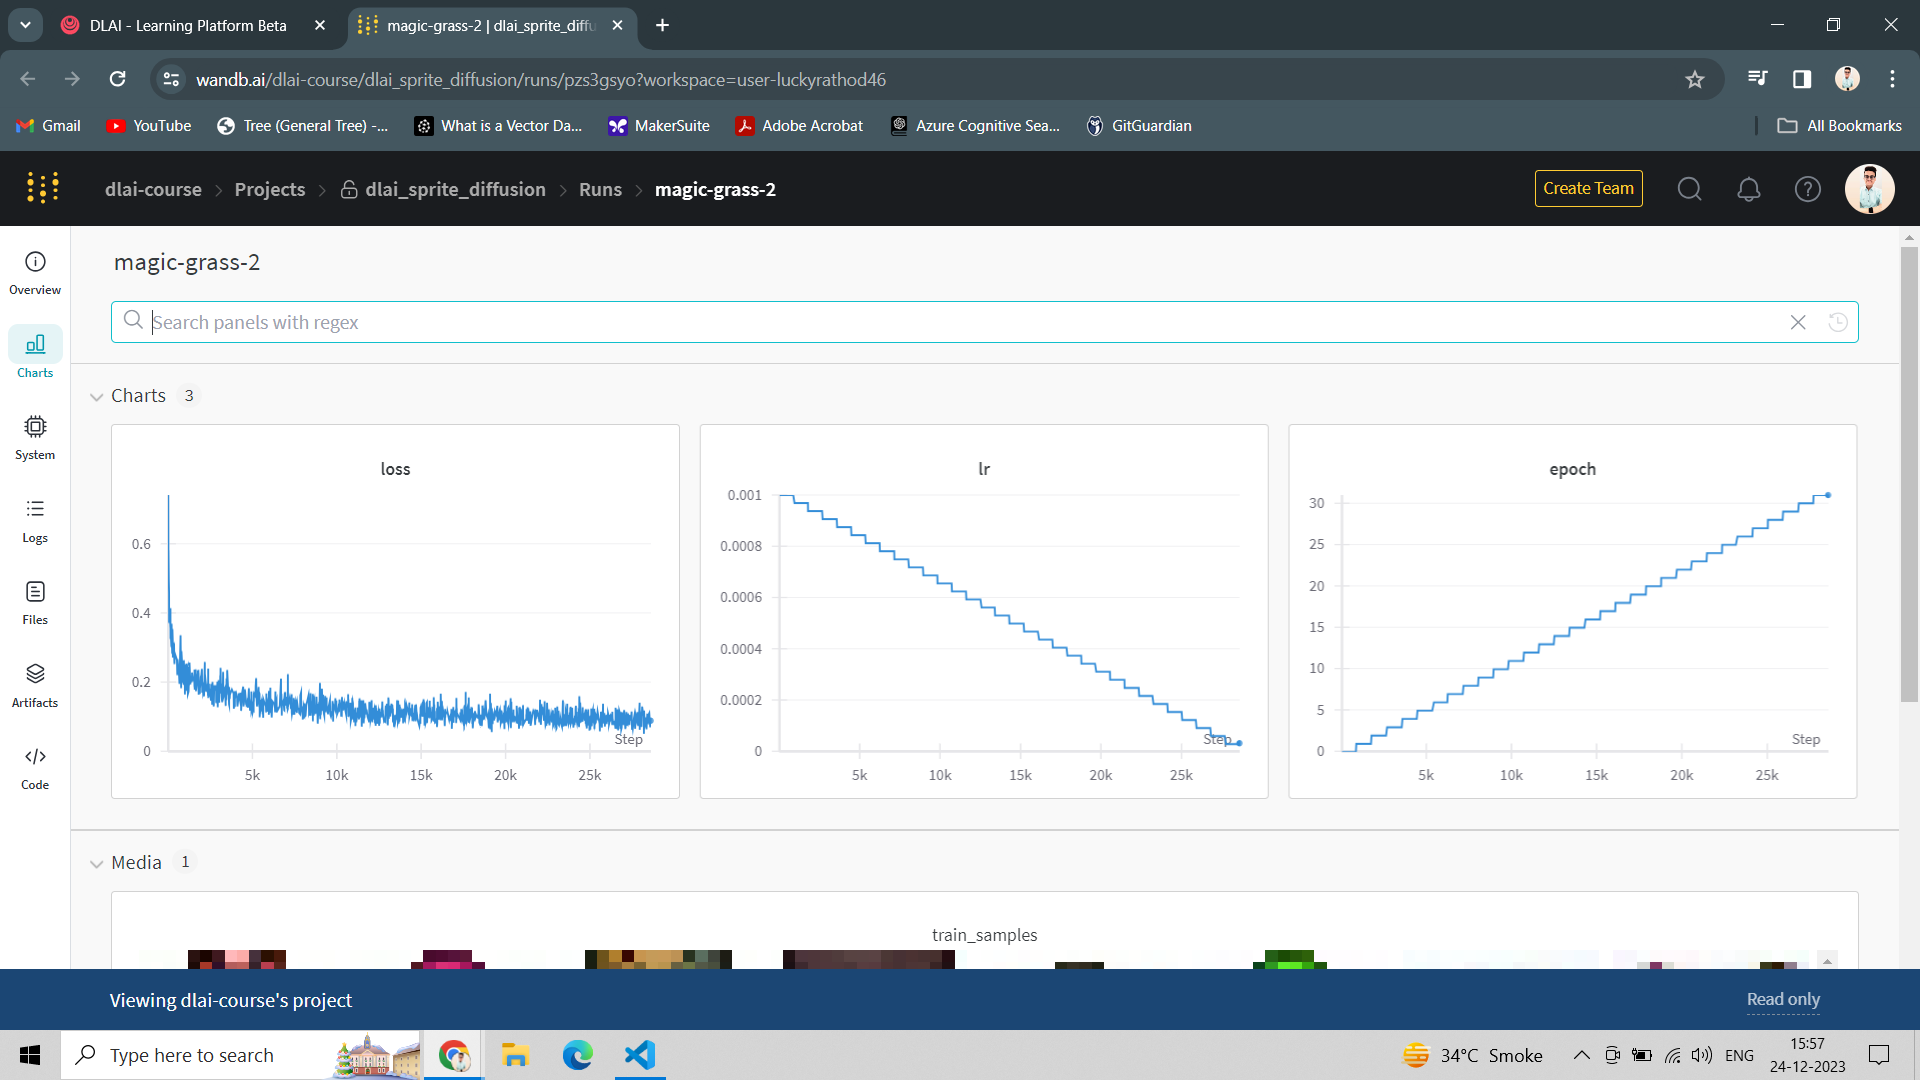

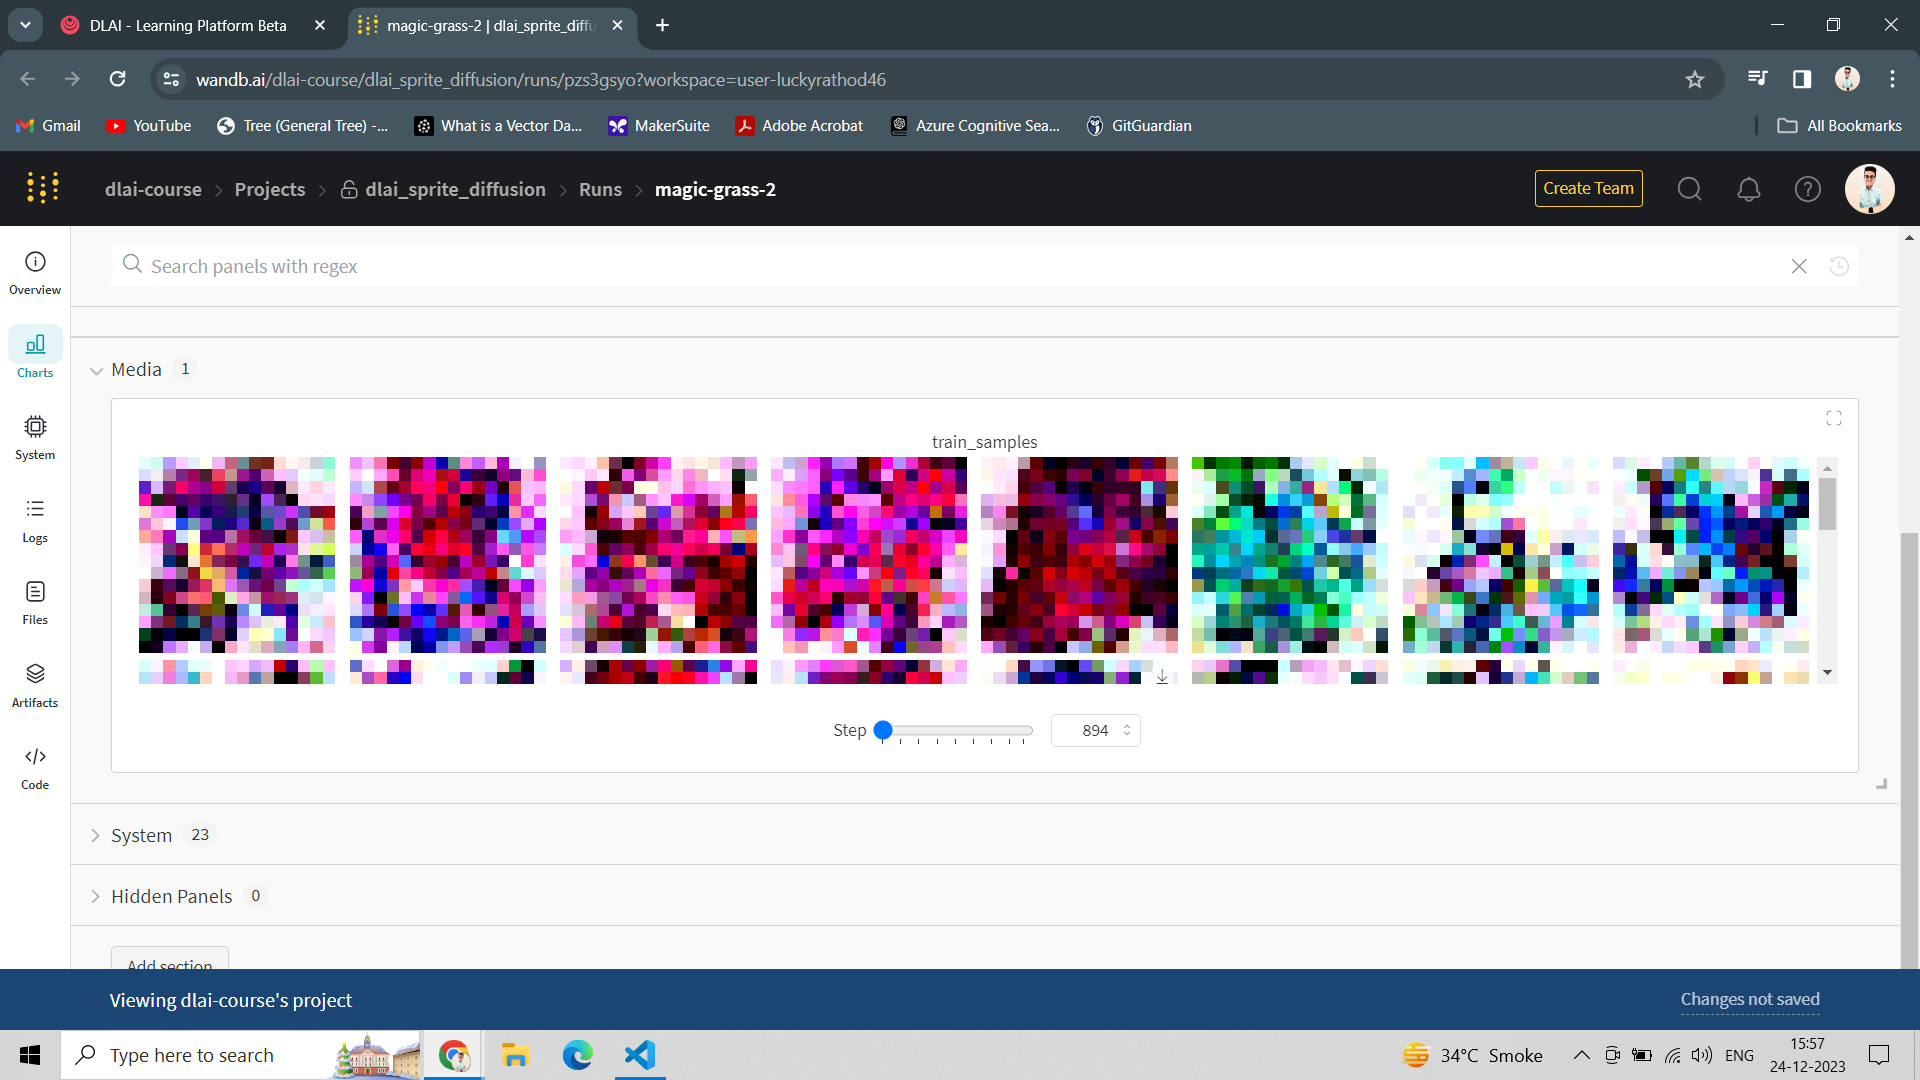

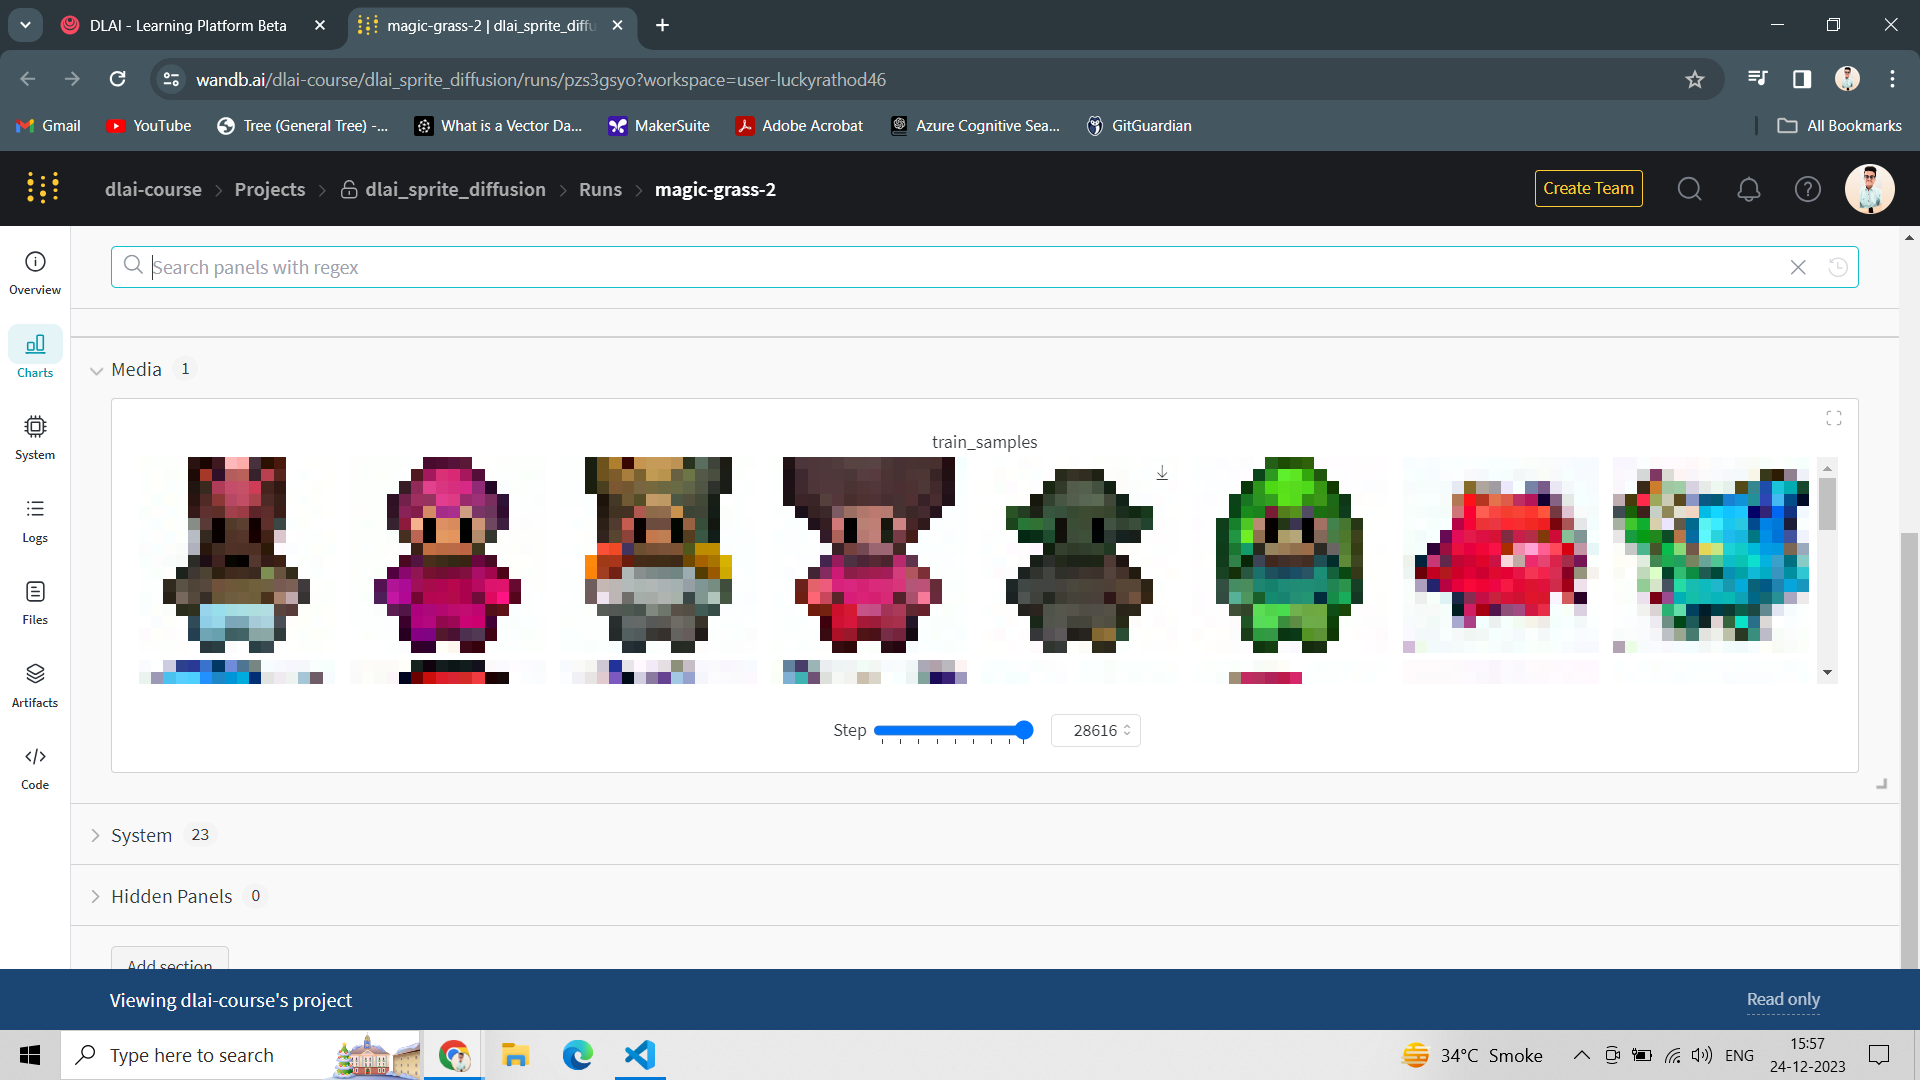

Will store latest model into model registry 

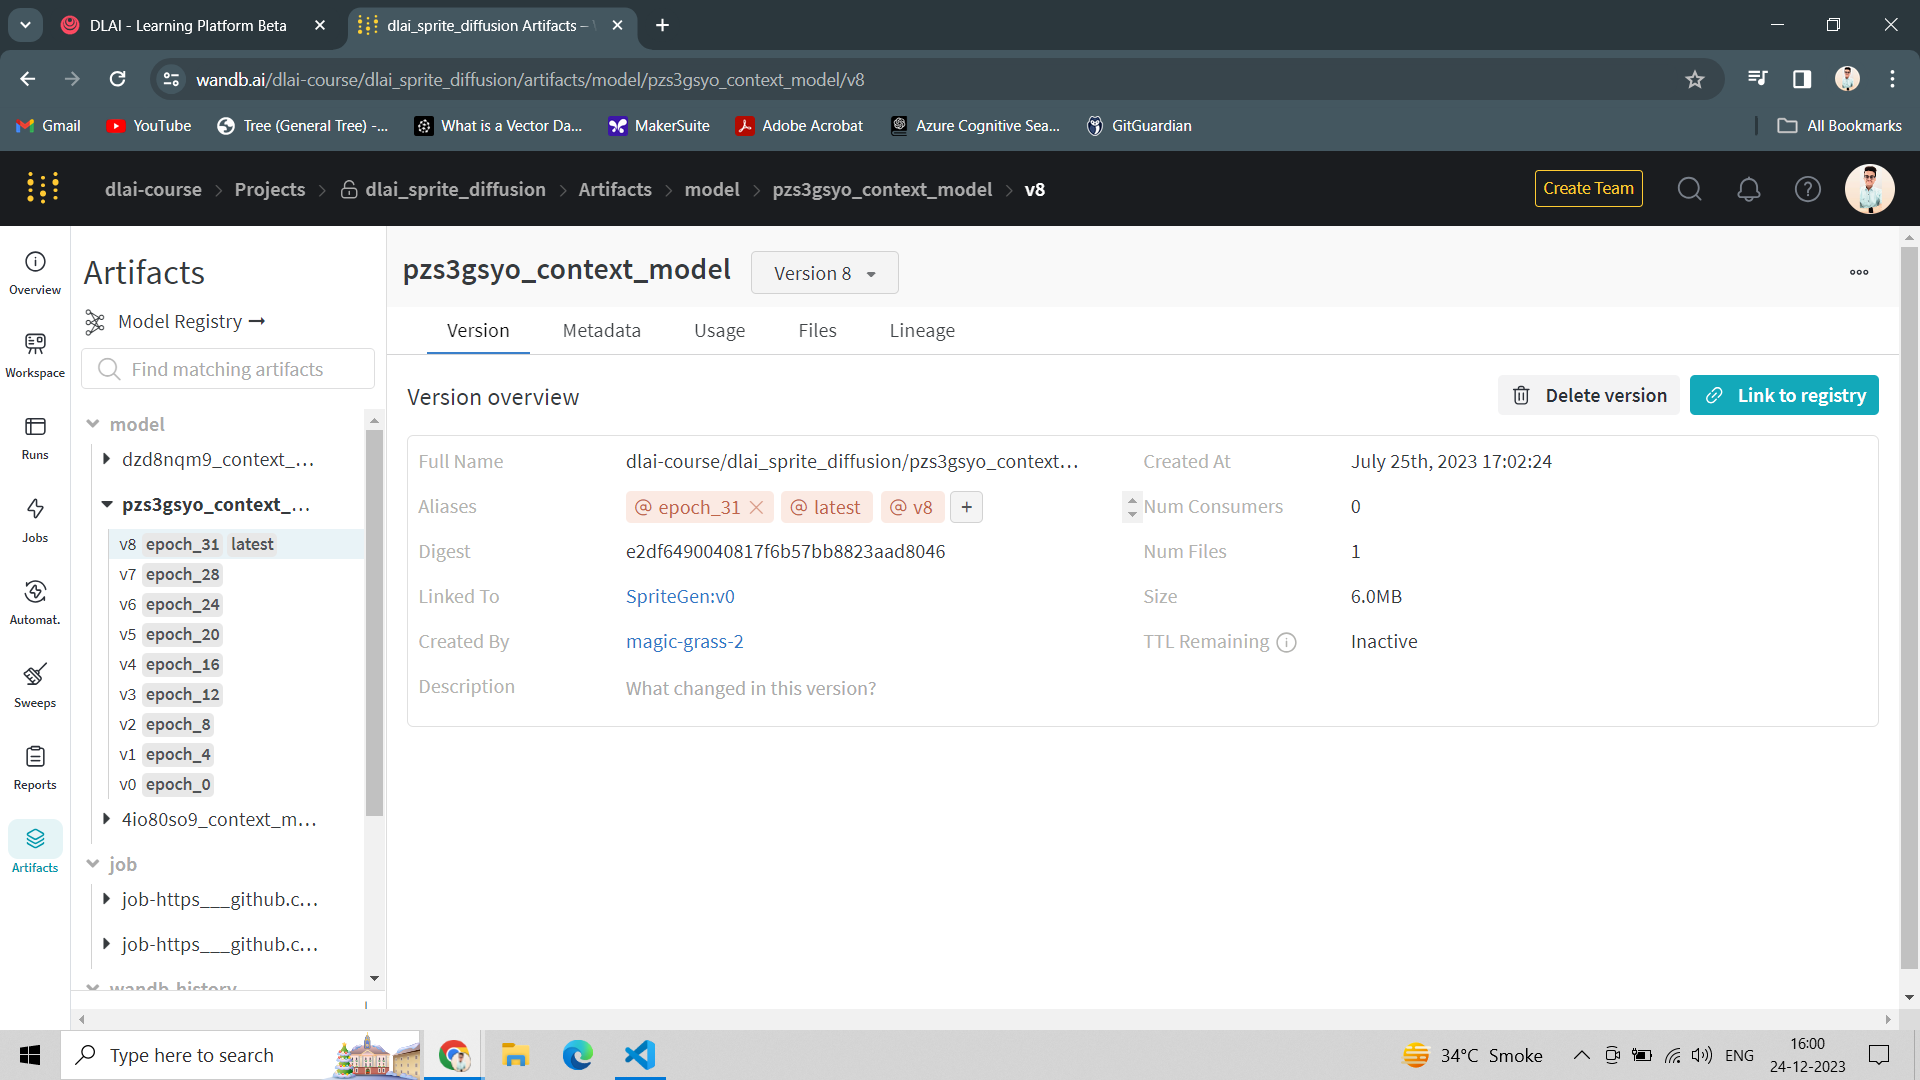

Clicked on Linked To Link - It will show you model which is registered

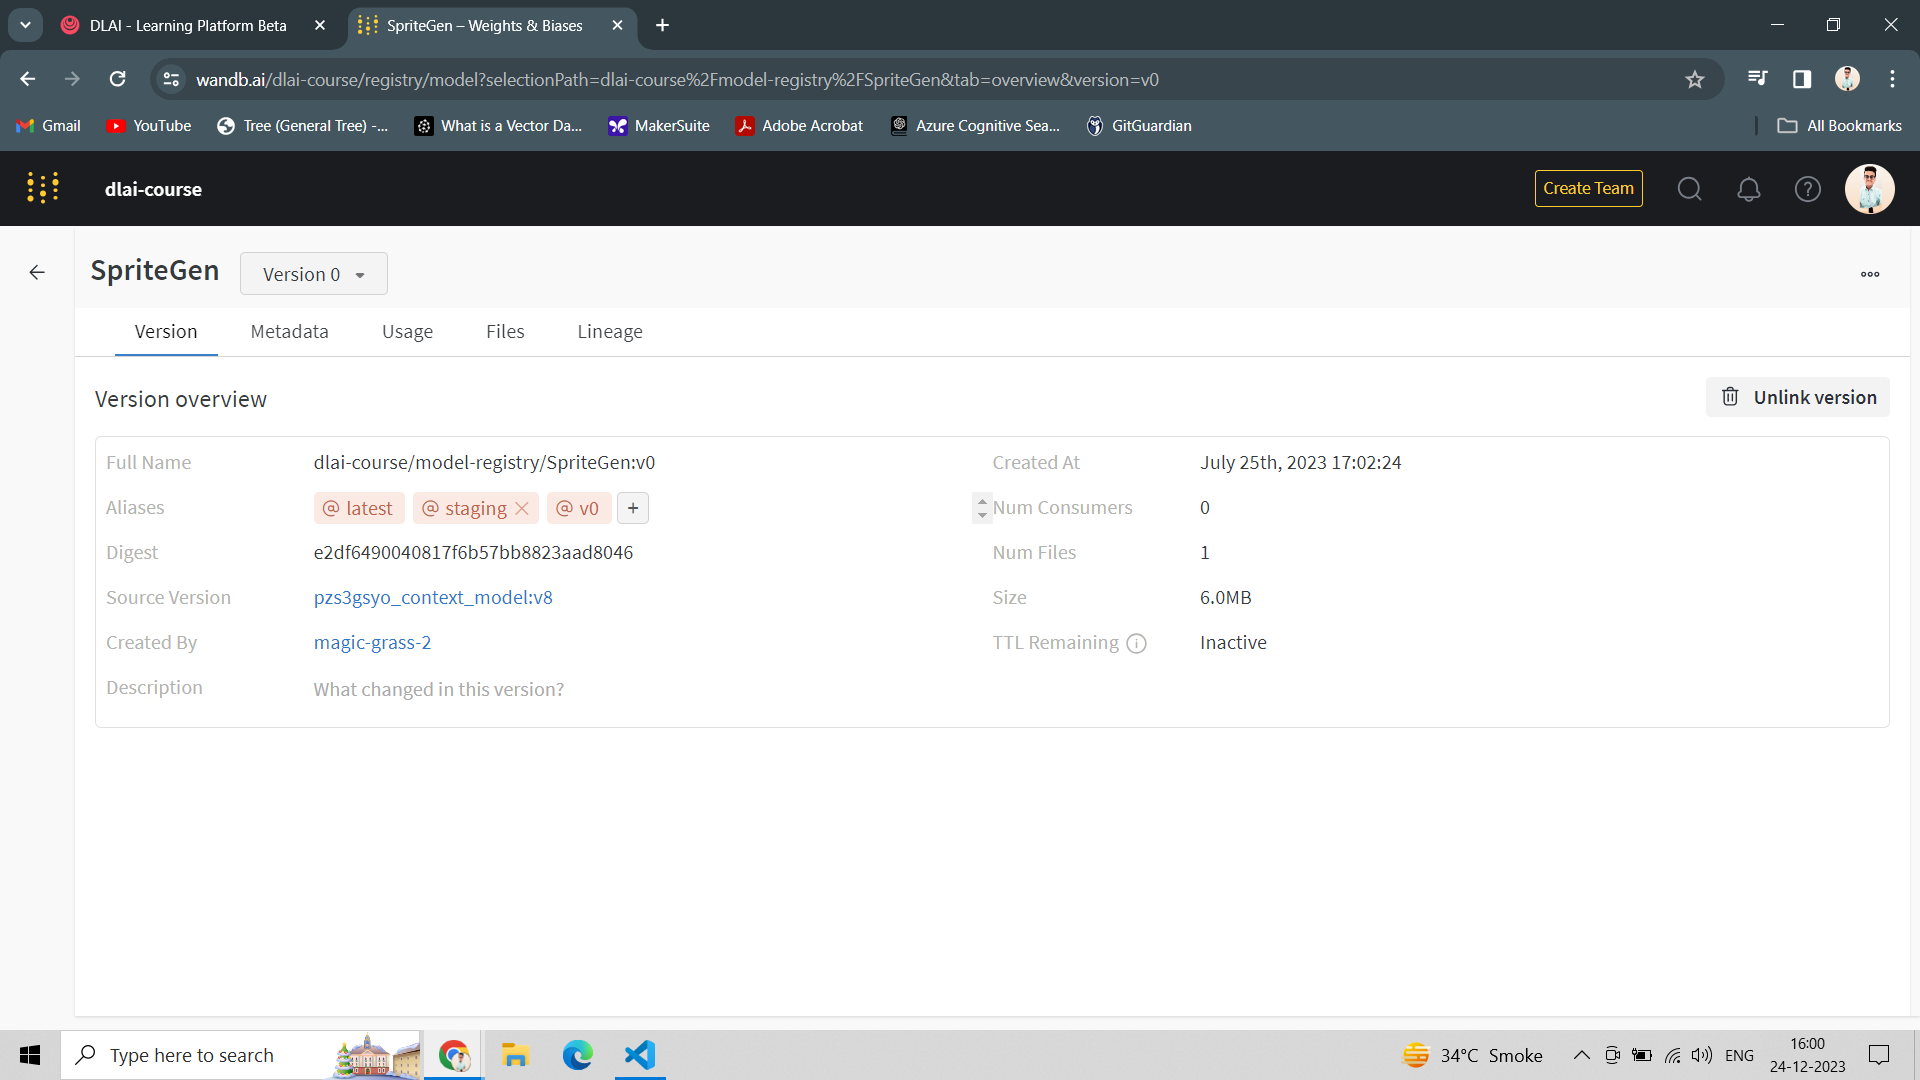

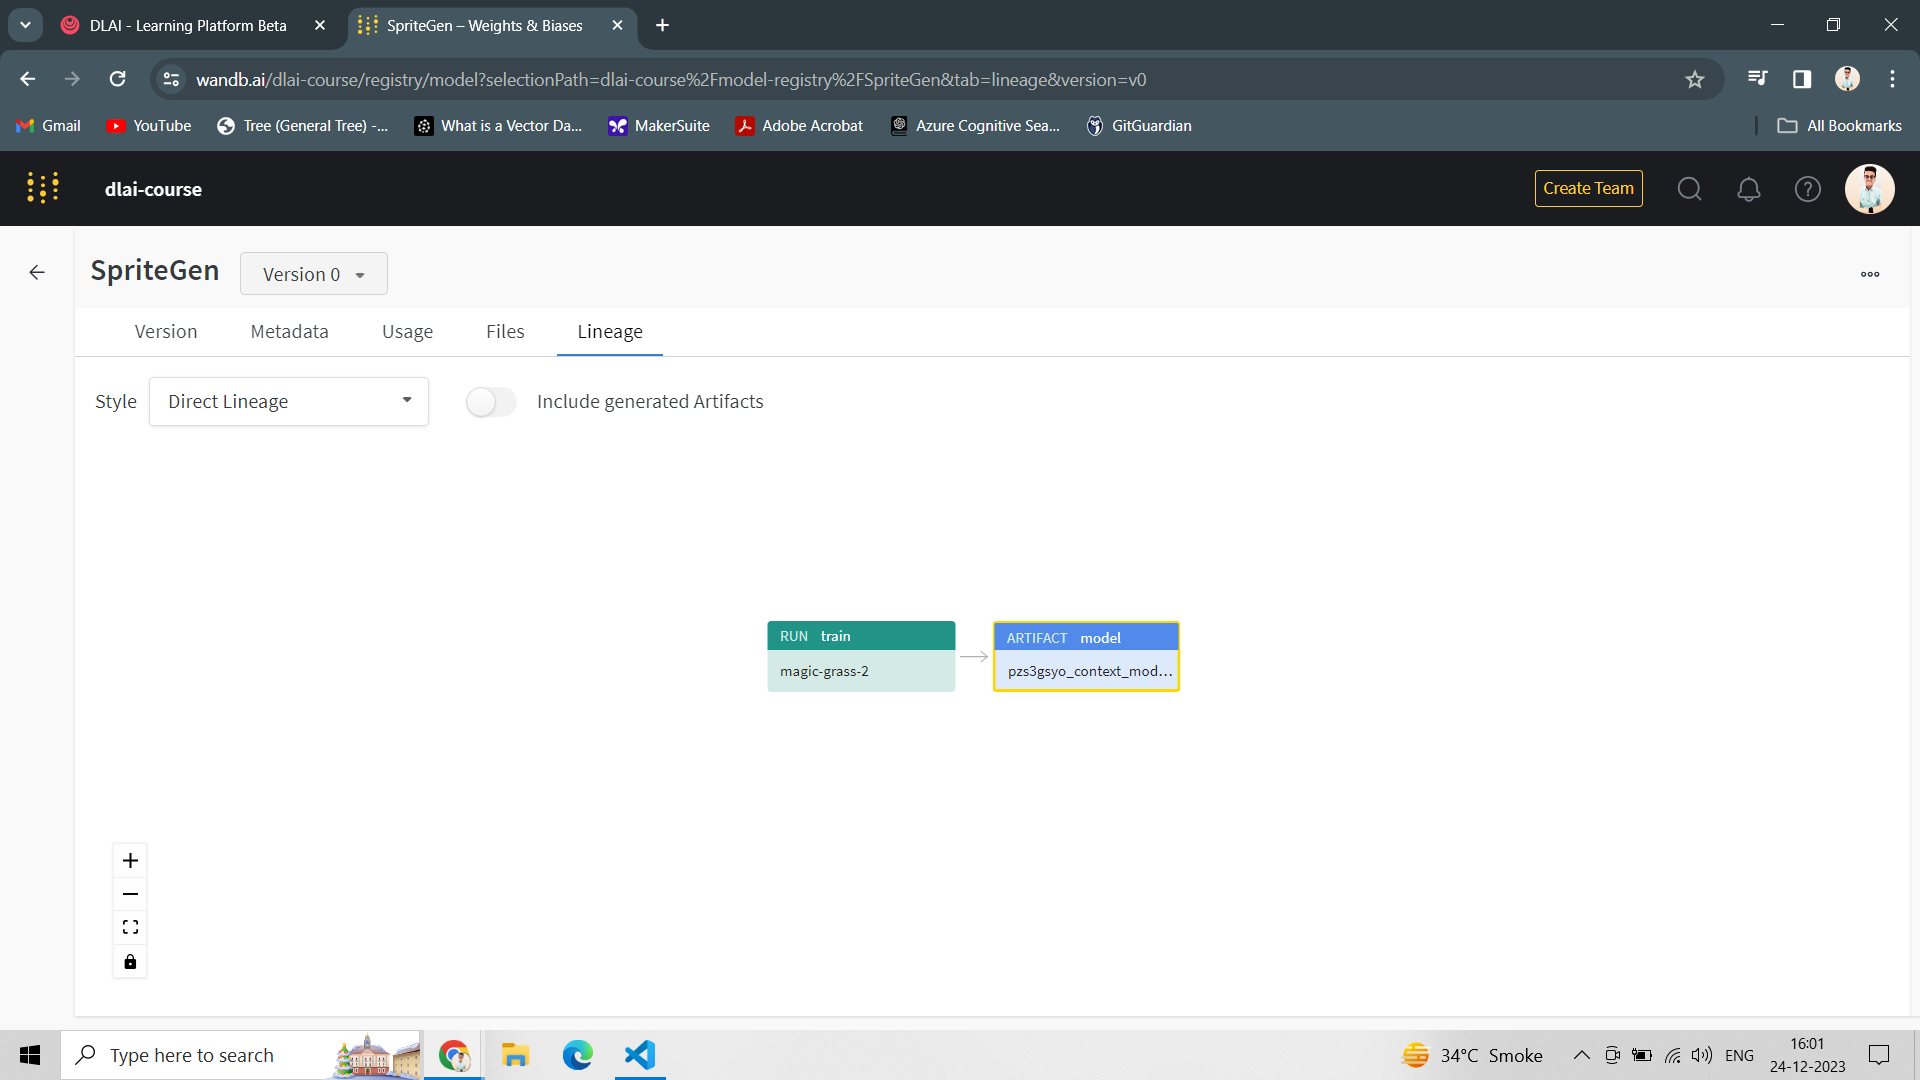